#### Firm's Problem

Let $\mathbf{x} = (a,k)$ denote the vector of **endogenous state variables**, $\mathbf{z} = (z^T,z^P)$ denote the vector of **exogenous idiosyncratic states**, and $\mathbf{\Omega} = (w,r)$ the vector of **aggregate states**


$$V(\mathbf{x},\mathbf{Z};\mathbf{\Omega}) = \max_{ c,a',k',l  } u(c)+ \beta \mathbb{E} V(\mathbf{x}',\mathbf{Z}';\mathbf{\Omega}')$$

$$c + a' + \phi(k,k') = p(y) y - w l - (r + \delta) k + (1+r)a$$

$$y = z k^\alpha l^{1-\alpha}$$

$$y = p^{-\theta}$$

$$k' \leq \lambda(k',a')$$

##### Productivity

$$z = z^P \exp(z^T) $$

$$z^{T\prime} = - \frac{\sigma^2}{2(1+\rho)} + \rho z^T + \sigma u^{z\prime} \quad \text{with } u^z \sim N(0,1)$$

$$z^P =
\left\{
\begin{array}{ll}
      z_L & \text{with prob } \pi \\
      z_H & \text{with prob } 1-\pi \\
\end{array}
\right.$$

##### Borrowing Constraints

$$k' \leq \lambda_0 a' + \lambda_1 \Psi (k')$$

$$\Psi (k) = \exp(k) - 1$$

###### Capital Adjustment Costs

$$\phi(k,k') = \frac{\psi (k' - k)}{2k} $$

In [1]:
!pip install quantecon
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import seaborn as sns
import numpy as np
import pandas as pd
from numba import jit, njit, prange
from quantecon import MarkovChain
from quantecon.markov.approximation import tauchen
import jax
import jax.numpy as jnp
!nvidia-smi
jax.config.update("jax_enable_x64", True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.4/215.4 kB 18.4 MB/s eta 0:00:00
Sat Nov 30 21:35:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |           

In [2]:
def Model(β    = 0.865,
          γ    = 2.00,
          δ    = 0.06,
          θ    = 3.00,
          α    = 0.35,
          ρ    = 0.59,
          σ    = 0.13,
          π    = 0.80,
          zl   = 0.785,
          zh   = 1.860,
          ψ    = 3.20,
          λ0   = 0.98,
          λ1   = 0.047,
          w    = 1.00,
          r    = 0.10,
          ):

  mc = tauchen(n = 11, rho = ρ, sigma = σ, mu = -(σ**2)/(2*(1+ρ)), n_std = 3)
  ztg, ztp  = mc.state_values, mc.P

  zp = jnp.kron(np.eye(2), ztp)
  zg = jnp.concatenate(( zl*jnp.exp(ztg) , zh*jnp.exp(ztg) ))
  zn = jnp.size(zg, 0)
  ag = jnp.linspace(start = 0.01, stop = 3.00, num = 120)
  kg = jnp.linspace(start = 0.01, stop = 6.00, num = 120)
  an, kn = jnp.size(ag, 0), jnp.size(kg, 0)

  xga, xgk = jnp.meshgrid(ag, kg, indexing='ij')
  xg = jnp.vstack([xga.ravel(), xgk.ravel()]).T
  xn = jnp.size(xg,0)

  xd_f = xg[:,1] <= λ0 * xg[:,0] + λ1 * (jnp.exp(xg[:,1]) - 1) # dummies for feasible (a,k) combo
  xi_f = jnp.arange(xn)[xd_f] # indices of feasible (a,k) combos
  xg_f = xg[ xi_f ,:] # values of feasible (a,k) combos
  xn_f = jnp.size(xg_f,0)

  agx, kgx = xg[:,0], xg[:,1]
  agx_f, kgx_f = xg_f[:,0], xg_f[:,1]

  params  = β ,γ ,δ ,θ ,α ,ρ ,σ ,π ,zl,zh,ψ ,λ0,λ1,w ,r
  sizes = xn_f, zn
  arrays = agx_f, kgx_f, zg, zp

  # Shift arrays to the device (e.g., GPU)
  arrays = tuple(map(jax.device_put, arrays))

  return params, sizes, arrays

In [3]:
def _B(v, params, arrays, i, j, ip):

    β ,γ ,δ ,θ ,α ,ρ ,σ ,π ,zl,zh,ψ ,λ0,λ1,w ,r = params
    ag, kg, zg, zp = arrays

    a, k, z, ap, kp  = ag[i], kg[i], zg[j], ag[ip], kg[ip]

    μ = θ / (θ - 1)
    l = (z * (k ** α) )**((θ - 1)/(1 + α*(θ-1))) * ((μ * w) / (1-α))**(-θ / (1 + α*(θ-1)))
    y = z * (k ** α) * (l ** (1-α))
    pi = y ** ((θ-1)/θ) - w * l - (r+δ) * k + (1+r) * a

    adj = ψ * ( (kp - k) ** 2 ) / ( 2 * k )
    c = pi - adj - ap

    u = (c ** (1-γ) - 1) / (1-γ)

    EV = jnp.sum(v[ip, :] * zp[j, :])

    return jnp.where(c > 0, u + β * EV, -jnp.inf)

In [4]:
B_1    = jax.vmap(_B,  in_axes=(None, None, None, None, None, 0))
B_2    = jax.vmap(B_1, in_axes=(None, None, None, None, 0,    None))
B_vmap = jax.vmap(B_2, in_axes=(None, None, None, 0,    None, None))

In [5]:
def B(v, params, sizes, arrays):
    xn, zn = sizes
    xind, yind = jnp.arange(xn), jnp.arange(zn)
    return B_vmap(v, params, arrays, xind, yind, xind)

B = jax.jit(B, static_argnums=(2,))

In [6]:
def T(v, params, sizes, arrays):
    "The Bellman operator."
    return jnp.max(B(v, params, sizes, arrays), axis=-1)

T = jax.jit(T, static_argnums=(2,))

In [7]:
def get_greedy(v, params, sizes, arrays):
    "Computes a v-greedy policy, returned as a set of indices."
    return jnp.argmax(B(v, params, sizes, arrays), axis=-1)

get_greedy = jax.jit(get_greedy, static_argnums=(2,))

In [8]:
def _compute_r_σ(pol_σ, params, arrays, i, j):

    # Unpack model
    β ,γ ,δ ,θ ,α ,ρ ,σ ,π ,zl,zh,ψ ,λ0,λ1,w ,r = params
    ag, kg, zg, zp = arrays
    # Compute r_σ[i, j]
    a, k, z, ap, kp  = ag[i], kg[i], zg[j], ag[pol_σ[i, j]], kg[pol_σ[i, j]]

    μ = θ / (θ - 1)
    l = (z * (k ** α) )**((θ - 1)/(1 + α*(θ-1))) * ((μ * w) / (1-α))**(-θ / (1 + α*(θ-1)))
    y = z * (k ** α) * (l ** (1-α))
    pi = y ** ((θ-1)/θ) - w * l - (r+δ) * k + (1+r) * a

    adj = ψ * ( (kp - k) ** 2 ) / ( 2 * k )
    c = pi - adj - ap

    r_σ = (c ** (1-γ) - 1) / (1-γ)

    return r_σ

In [9]:
r_1 = jax.vmap(_compute_r_σ,  in_axes=(None, None, None, None, 0))
r_σ_vmap = jax.vmap(r_1,      in_axes=(None, None, None, 0,    None))

In [10]:
def compute_r_σ(pol_σ, params, sizes, arrays):
    xn, zn = sizes

    xind, yind = jnp.arange(xn), jnp.arange(zn)
    return r_σ_vmap(pol_σ, params, arrays, xind, yind)

compute_r_σ = jax.jit(compute_r_σ, static_argnums=(2,))

In [11]:
def _T_σ(v, pol_σ, params, arrays, i, j):

    # Unpack model
    β ,γ ,δ ,θ ,α ,ρ ,σ ,π ,zl,zh,ψ ,λ0,λ1,w ,r = params
    ag, kg, zg, zp = arrays

    r_σ  = _compute_r_σ(pol_σ, params, arrays, i, j)
    # Calculate the expected sum Σ_jp v[σ[i, j], jp] * Q[i, j, jp]
    EV = jnp.sum(v[pol_σ[i, j], :] * zp[j, :])

    return r_σ + β * EV


T_1 = jax.vmap(_T_σ,      in_axes=(None, None, None, None, None, 0))
T_σ_vmap = jax.vmap(T_1,  in_axes=(None, None, None, None, 0,    None))

def T_σ(v, pol_σ, params, sizes, arrays):
    xn, zn = sizes
    xind, yind = jnp.arange(xn), jnp.arange(zn)
    return T_σ_vmap(v, pol_σ, params, arrays, xind, yind)

T_σ = jax.jit(T_σ, static_argnums=(3,))

In [12]:
def _L_σ(v, pol_σ, params, arrays, i, j):

    # Unpack
    β ,γ ,δ ,θ ,α ,ρ ,σ ,π ,zl,zh,ψ ,λ0,λ1,w ,r = params
    ag, kg, zg, zp = arrays
    # Compute and return v[i, j] - β Σ_jp v[σ[i, j], jp] * Q[j, jp]
    return v[i, j]  - β * jnp.sum(v[pol_σ[i, j], :] * zp[j, :])

L_1 = jax.vmap(_L_σ,      in_axes=(None, None, None, None, None, 0))
L_σ_vmap = jax.vmap(L_1,  in_axes=(None, None, None, None, 0,    None))

def L_σ(v, pol_σ, params, sizes, arrays):
    xn, zn = sizes
    xind, yind = jnp.arange(xn), jnp.arange(zn)
    return L_σ_vmap(v, pol_σ, params, arrays, xind, yind)

L_σ = jax.jit(L_σ, static_argnums=(3,))

In [13]:
def get_value(pol_σ, params, sizes, arrays):
    "Get the value v_σ of policy σ by inverting the linear map L_σ."

    # Unpack
    β ,γ ,δ ,θ ,α ,ρ ,σ ,π ,zl,zh,ψ ,λ0,λ1,w ,r = params
    ag, kg, zg, zp = arrays

    r_σ = compute_r_σ(pol_σ, params, sizes, arrays)

    # Reduce L_σ to a function in v
    partial_L_σ = lambda v: L_σ(v, pol_σ, params, sizes, arrays)

    return jax.scipy.sparse.linalg.bicgstab(partial_L_σ, r_σ)[0]

get_value = jax.jit(get_value, static_argnums=(2,))

In [14]:
def successive_approx_jax(T,                     # Operator (callable)
                          x_0,                   # Initial condition
                          tol=1e-6,              # Error tolerance
                          max_iter=10_000):      # Max iteration bound
    def update(inputs):
        k, x, error = inputs
        x_new = T(x)
        error = jnp.max(jnp.abs(x_new - x))
        return k + 1, x_new, error

    def condition_function(inputs):
        k, x, error = inputs
        return jnp.logical_and(error > tol, k < max_iter)

    k, x, error = jax.lax.while_loop(condition_function,
                                     update,
                                     (1, x_0, tol + 1))
    return x

successive_approx_jax = jax.jit(successive_approx_jax, static_argnums=(0,))

In [15]:
def iterate_policy_operator(pol_σ, v, m, params, sizes, arrays):

    def update(i, v):
        v = T_σ(v, pol_σ, params, sizes, arrays)
        return v

    v = jax.lax.fori_loop(0, m, update, v)
    return v

iterate_policy_operator = jax.jit(iterate_policy_operator,
                                  static_argnums=(4,))

In [16]:
def value_function_iteration(model, tol=1e-5):
    """
    Implements value function iteration.
    """
    params, sizes, arrays = model
    vz = jnp.zeros(sizes)
    _T = lambda v: T(v, params, sizes, arrays)
    v_star = successive_approx_jax(_T, vz, tol=tol)
    return get_greedy(v_star, params, sizes, arrays)

In [17]:
def policy_iteration(model, maxiter=250):
    """
    Implements Howard policy iteration (see dp.quantecon.org)
    """
    params, sizes, arrays = model
    pol_σ = jnp.zeros(sizes, dtype=int)
    i, error = 0, 1.0
    while error > 0 and i < maxiter:
        v_σ = get_value(pol_σ, params, sizes, arrays)
        σ_new = get_greedy(v_σ, params, sizes, arrays)
        error = jnp.max(jnp.abs(σ_new - pol_σ))
        pol_σ = σ_new
        i = i + 1
        # print(f"Concluded loop {i} with error {error}.")
    print(f"Concluded after {i} iterations with error {error}.")
    return pol_σ

In [18]:
@njit(parallel=True)
def simul_x(pol_x,hist_x,hist_z,N,T):
    for i in prange(N):
        for t in range(T-1):
            hist_x[i,t+1] = pol_x[hist_x[i,t],hist_z[i,t]]
    return hist_x

In [19]:
def simul(pol_x,N,T,
          constants, sizes, arrays,
          dist_x,
          verbose = True):

    β ,γ ,δ ,θ ,α ,ρ ,σ ,π ,zl,zh,ψ ,λ0,λ1,w ,r = constants
    xn, zn = sizes
    ag, kg, zg, zp = arrays

    hist_x = np.zeros((N,T)).astype(int)
    hist_x[:,0] = dist_x

    np.random.seed(1234)
    mc = MarkovChain(zp)

    init_z = np.concatenate( (  np.full( int(N*π) , int(0.25*zn) ), np.full( N - int(N*π) , int(0.75*zn)) )  )
    hist_z = mc.simulate_indices(ts_length = T, init = init_z)

    hist_x = simul_x(pol_x,hist_x,hist_z,N,T)

    if verbose:
        print('Simulations complete!')

    return hist_x, hist_z

In [20]:
model = Model()
constants, sizes, arrays = model
ag, kg, zg, zp = arrays
xn, zn = sizes

In [21]:
rg = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.10])
rn = len(rg)

pol_x_r, pol_a_r, pol_k_r = np.zeros((xn,zn,rn)), np.zeros((xn,zn,rn)), np.zeros((xn,zn,rn))

for ri in range(rn):

    print("----------- r iteration:", ri + 1 ,"of", rn)

    model = Model(r = rg[ri])

    pol_x = policy_iteration(model, maxiter=20)

    pol_a, pol_k = ag[pol_x], kg[pol_x]

    pol_x_r[:,:,ri], pol_a_r[:,:,ri], pol_k_r[:,:,ri] = pol_x, pol_a, pol_k


----------- r iteration: 1 of 6
Concluded after 12 iterations with error 0.
----------- r iteration: 2 of 6
Concluded after 20 iterations with error 121.
----------- r iteration: 3 of 6
Concluded after 12 iterations with error 0.
----------- r iteration: 4 of 6
Concluded after 12 iterations with error 0.
----------- r iteration: 5 of 6
Concluded after 11 iterations with error 0.
----------- r iteration: 6 of 6
Concluded after 20 iterations with error 1138.


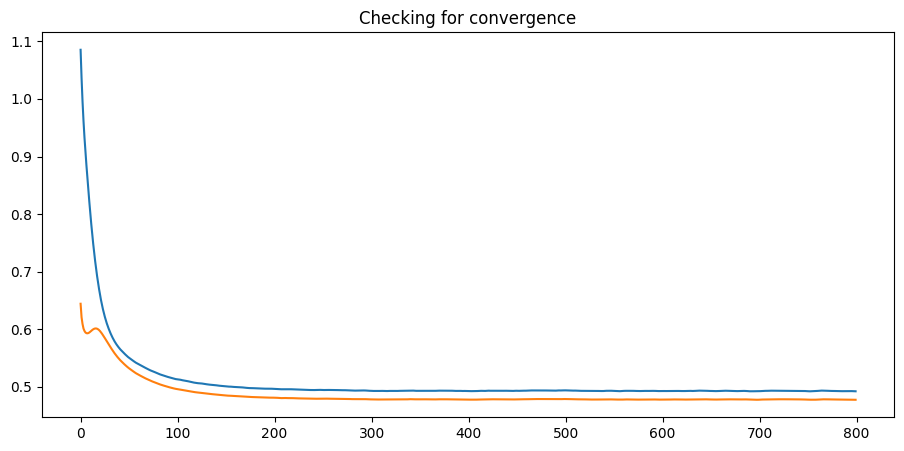

In [23]:
model = Model(r = rg[-1])
constants, sizes, arrays = model

N  = 250000
T  = 1000
Ts = 800

hist_x, hist_z = simul(pol_x_r[:,:,-1],N,Ts,constants, sizes, arrays,dist_x=np.ones(N)*2000,verbose=False)

hist_a = pol_a[hist_x,hist_z]
hist_k = pol_k[hist_x,hist_z]

evol_a = np.mean(hist_a, axis=0)
evol_k = np.mean(hist_k, axis=0)

plt.title('Checking for convergence')
plt.plot(evol_a)
plt.plot(evol_k)
plt.show()

In [25]:
r_path = np.array([6,6,5,5,5,4,3,1,2,2,1,1,1,1,2,3,2,3,2,2,2,2,2,2,2,2])-1

dist_x = hist_x[:,-1]
hist_x_t, hist_z_t = np.zeros((N,len(r_path))).astype(int), np.zeros((N,len(r_path))).astype(int)

for ri in range(len(r_path)):

    model = Model(r = rg[r_path[ri]])
    constants, sizes, arrays = model

    pol_x = pol_x_r[:,:,r_path[ri]]

    hist_x_temp, hist_z_temp = simul(pol_x,N,2,constants, sizes, arrays,dist_x=dist_x,verbose=False)

    hist_x_t[:,ri], hist_z_t[:,ri] = hist_x_temp[:,-1], hist_z_temp[:,-1]

    dist_x = hist_x_t[:,ri]

In [26]:
β ,γ ,δ ,θ ,α ,ρ ,σ ,π ,zl,zh,ψ ,λ0,λ1,w ,r = constants

hist_r_t = np.tile(r_path[:,np.newaxis].T,(N,1))

hist_a_t = pol_a_r[hist_x_t,hist_z_t,hist_r_t]
hist_k_t = pol_k_r[hist_x_t,hist_z_t,hist_r_t]

evol_a_t = np.mean(hist_a_t, axis=0)
evol_k_t = np.mean(hist_k_t, axis=0)

μ = θ / (θ - 1)

hist_l_t = (zg[hist_z_t] * (hist_k_t ** α) )**((θ - 1)/(1 + α*(θ-1))) * ((μ * w) / (1-α))**(-θ / (1 + α*(θ-1)))
hist_y_t = zg[hist_z_t] * (hist_k_t ** α) * (hist_l_t ** (1-α))
hist_p_t = hist_y_t ** (-1/θ)

hist_mrpl_t = ( (1-α) / μ) * ( hist_y_t ** ((θ-1)/θ) ) / hist_l_t
hist_mrpk_t = ( α / μ) * ( hist_y_t ** ((θ-1)/θ) ) / hist_k_t

evol_sdmrpl_t = np.std( np.log(hist_mrpl_t) , axis=0)
evol_sdmrpk_t = np.std( np.log(hist_mrpk_t) , axis=0)

hist_tfpr_t = μ * (( hist_mrpk_t / α ) ** α ) * (( hist_mrpl_t / (1-α) ) ** (1-α) )
evol_tfpr_t = np.mean(np.log(hist_tfpr_t), axis=0)

evol_logtfpa_t = np.log( ( np.sum( hist_y_t ** ((θ-1)/θ) , axis=0) ** (θ/(θ-1)) ) / ( ( np.sum( hist_k_t , axis=0) ** α ) * ( np.sum( hist_l_t , axis=0) ** (1-α) ) ) )
evol_logtfpe_t = np.log( np.sum( zg[hist_z_t] ** (θ-1) , axis=0) ** (1/(θ-1)) )

evol_dev_logtfp_t = evol_logtfpa_t - evol_logtfpe_t

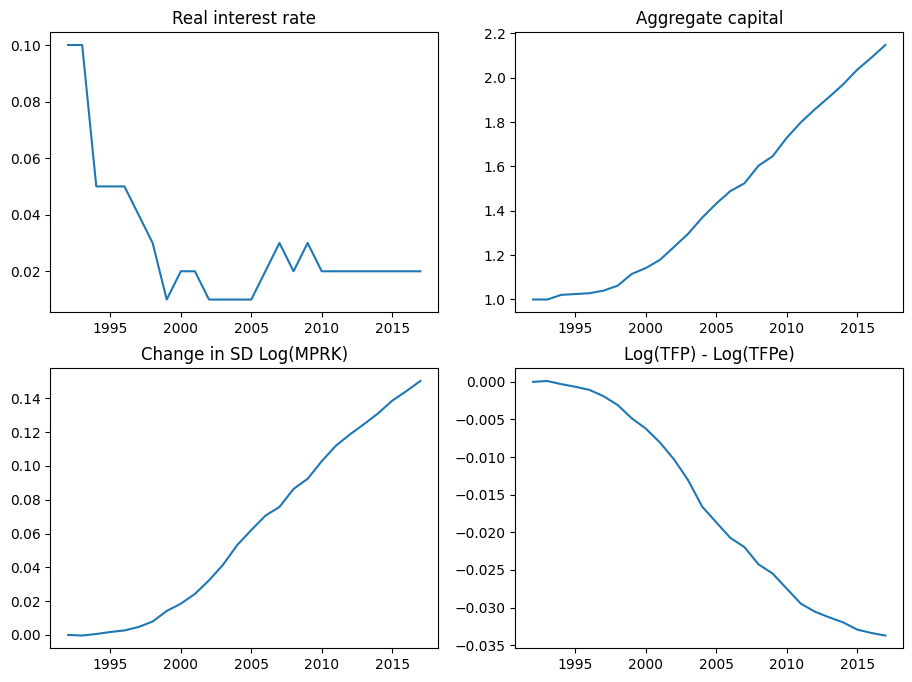

In [27]:
years = np.arange(1992,2017+1,dtype=int)

fig, ax = plt.subplots(2,2)
fig.set_size_inches(11, 8)
ax[0,0].plot(years, rg[r_path])
ax[0,0].set_title("Real interest rate")
ax[0,1].plot(years, evol_k_t / evol_k_t[0])
ax[0,1].set_title("Aggregate capital")
ax[1,0].plot(years, evol_sdmrpk_t - evol_sdmrpk_t[0])
ax[1,0].set_title("Change in SD Log(MPRK)")
ax[1,1].plot(years, evol_dev_logtfp_t - evol_dev_logtfp_t[0])
ax[1,1].set_title("Log(TFP) - Log(TFPe)")

plt.show()